## Tratamiento de valores atípicos


Un valor atípico o valor extremo (outlier) es un valor el cual es significativamente diferente del resto de los datos. “Un outlier es una observación la cual se desvía tanto del resto de las observaciones que levanta sospechas sobre el mecanismo que lo generó” [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980].

Valores estadísticos como la media y la varianza son susceptibles a los valores extremos. Además, **algunos modelos de Machine Learning son susceptibles a los outliers** lo cual decrece su desempeño. Por lo tanto, dependiendo de cuál algoritmo deseas usar para entrenar un modelo, es muy común que sea necesario remover los valores atípicos de las variables.

Discutimos en la sección 3, cómo identificar los outliers. En esta sección vamos a discutir cómo podemos procesarlos para entrenar nuestros modelos de machine learning o aprendizaje automático. 

Es importante resaltar que con cada modificación que hacemos en nuestros datos, introducimos algún sesgo. Por eso es muy importante saber cuáles son las implicaciones de cada método. Si es una buena decisión o no dependerá de la naturaleza de los datos que estemos analizando.

## Cómo podemos pre-procesar los valores extremos?

- Removerlos: eliminar los valores extremos de nuestro conjunto de datos
- Tratar los outliers como datos faltantes y proceder con cualquiera de las técnicas de sustitución
- Discretización: los datos son discretizados ( ver sección 8) y los valores atípicos son colados en los segmentos extremos junto con los valores más bajos y altos del conjunto de datos
- Truncamiento de valores: Limitar la distribución de la variable a unos valores máximos y mínimos. También se le conoce como codificación Top / Bottom 

**El truncamiento de valores** se conoce en inglés como capping, trimming, censoring o winsorization.


## Remoción de los valores extremos

Remover los valores extremos, como su nombre lo indica, consiste en eliminar las observaciones que contiene valores extremos del conjunto de datos. Solo tenemos que decidir en una métrica para determinar qué valores consideramos extremos o atípicos. Como vimos en la sección 3, esto se puede hacer con una aproximación Gaussiana para variables que están normalmente distribuidas o utilizando la regla de proximidad del rango inter-cuantil para las variables sesgadas.


### Ventajas

- rápido

### Limitaciones

- las observaciones con valores extremos en una variable pueden contener información importante en las otras variables
- si hay valores extremos en muchas variables, podemos terminar removiendo una gran proporción de nuestro conjunto de datos.

## En este Demo

Aprenderás cómo remover las observaciones con valores extremos utilizando el Boston House Dataset

## Importante

Outliers deben ser identificados Y **removidos SOLAMENTE** del set de entrenamiento y NO del set de prueba.

Por lo tanto, primero es necesario dividir el conjunto de datos en los set de entrenamiento y prueba, y luego si remover los valores extremos del set de entrenamiento, pero mantenerlos en el set de prueba y evaluar el desempeño de nuestro modelo.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Para la gráficas Q-Q 
import scipy.stats as stats

# datos Boston house price - precios casas de Boston
from sklearn.datasets import load_boston

In [2]:
# Cargar los datos de precios casas de Boston de sklearn
boston_dataset = load_boston()

# crear un dataframe  con las variables independientes
# Usaremos solo 3 variables en este demo
boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

boston.head()

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905


In [3]:
# Función para crear histograma, gráfico Q-Q y
# gráfico de caja. 
# Esto lo aprendimos en la sección 3 del curso

def diagnostic_plots(df, variable):
    # la función toma un dataframe (df) y
    # la variable de interés como argumento

    # define el tamaño de la gráfica
    plt.figure(figsize=(16, 4))

    # histograma
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # gráfica Q-Q 
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Cuantiles de la variable')

    # gráfico de caja 
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Gráfico de caja')

    plt.show()

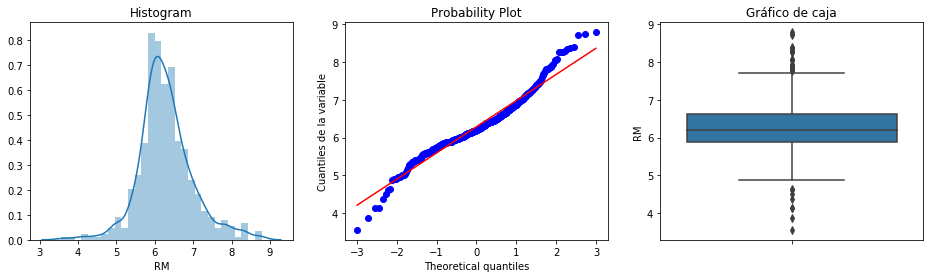

In [4]:
# identifiquemos los valores extremos en RM

diagnostic_plots(boston, 'RM')

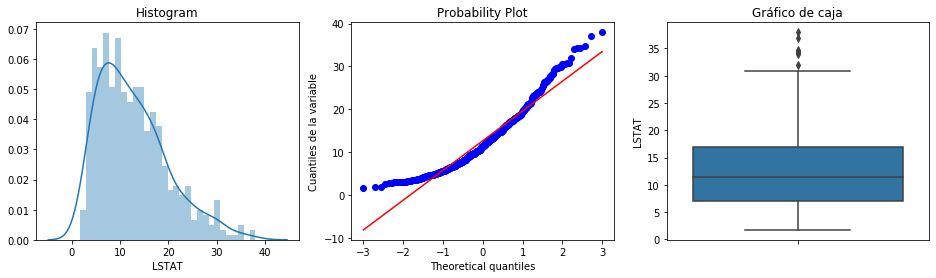

In [5]:
# visualizar los valores extremos en LSTAT

diagnostic_plots(boston, 'LSTAT')

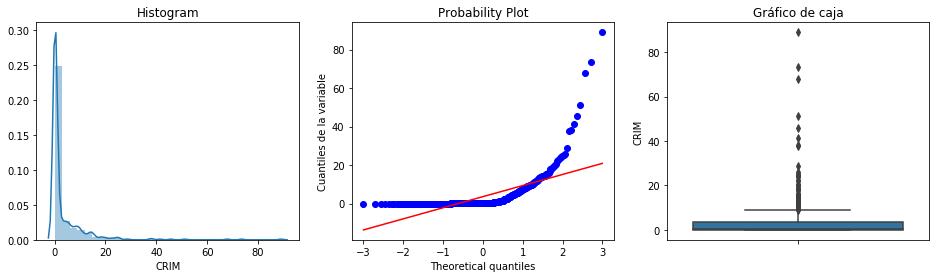

In [6]:
# valores extremos en la variable CRIM

diagnostic_plots(boston, 'CRIM')

Hay valores extremos presentes en todas las variables. RM tiene outliers en ambos extremos, mientras que LSTAT y CRIM only en el extremo derecho.

Para identificar los outliers, re-utilicemos la funcíon que aprendimos en la sección 3:

In [7]:
def find_skewed_boundaries(df, variable, distance):

    # Calculemos los extremos afuera de los cuales
    # se encuentran los outliers para las distribuciones
    # sesgadas.
    
    # 'distance' es un argumento que ofrece la opción de 
    # estimar los extremos a 1.5 o 3 del rango 
    # intercuantil IQR

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [8]:
# Encontremos los límites para la variable RM

RM_upper_limit, RM_lower_limit = find_skewed_boundaries(boston, 'RM', 1.5)
RM_upper_limit, RM_lower_limit

(7.730499999999999, 4.778500000000001)

In [9]:
# Encontremos los límites para la variable LSTAT

LSTAT_upper_limit, LSTAT_lower_limit = find_skewed_boundaries(boston, 'LSTAT', 1.5)
LSTAT_upper_limit, LSTAT_lower_limit

(31.962500000000006, -8.057500000000005)

In [10]:
# Encontremos los límites para la variable CRIM

CRIM_upper_limit, CRIM_lower_limit = find_skewed_boundaries(boston, 'CRIM', 1.5)
CRIM_upper_limit, CRIM_lower_limit

(9.06963875, -5.31051125)

In [11]:
# Marquemos los outliers los datos

outliers_RM = np.where(boston['RM'] > RM_upper_limit, True,
                       np.where(boston['RM'] < RM_lower_limit, True, False))

In [12]:
# Marquemos los outliers los datos

outliers_LSTAT = np.where(boston['LSTAT'] > LSTAT_upper_limit, True,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, True, False))

In [13]:
# Marquemos los outliers los datos

outliers_CRIM = np.where(boston['CRIM'] > CRIM_upper_limit, True,
                       np.where(boston['CRIM'] < CRIM_lower_limit, True, False))

In [14]:
# Trunquemos los datos

boston_trimmed = boston.loc[~(outliers_RM + outliers_LSTAT + outliers_CRIM), ]

boston.shape, boston_trimmed.shape

((506, 3), (416, 3))

Podemos ver que al remover los valores extremos, eliminamos casi 100 observaciones (filas) de las 500 presentes en los datos.  Removimos el 20% del total de los datos, por esta razón, el truncamiento de los valores extremos no se usa mucho los modelos de machine learning. Pero si solo una pequeña proporción de las variables tiene outliers, truncamiento puede funcionar. 

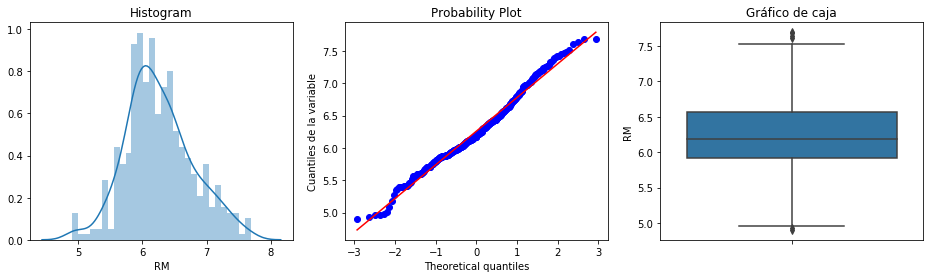

In [15]:
# exploremos los valores extremos en los datos removidos
# para la variable RM vemos muchos menos outliers 
# que en los datos originales
diagnostic_plots(boston_trimmed, 'RM')

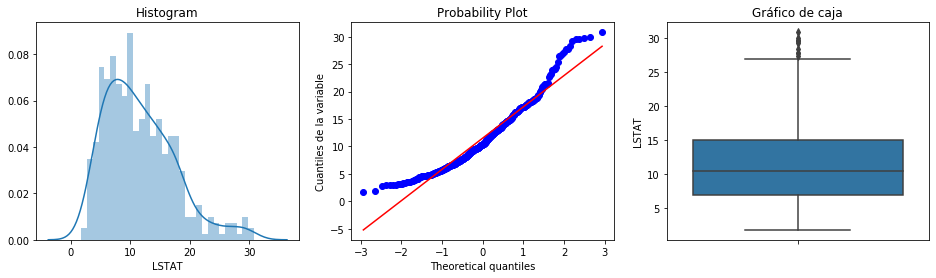

In [16]:
diagnostic_plots(boston_trimmed, 'LSTAT')

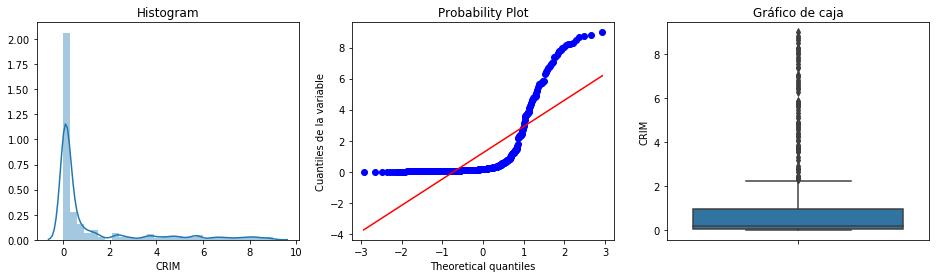

In [17]:
diagnostic_plots(boston_trimmed, 'CRIM')

Para las variables LSTAT y CRIM, todavía vemos muchos valores extremos. Cuando removemos observaciones del conjunto de datos, todos los parámetros de la distribución son recalculados: la media, los cuantiles y el rango inter-cuantil, por lo tanto valores que antes no eran considerados outliers ahora si lo son!

Esta es una característica no deseada de este método para lidiar con valores extremos. 